# Modeling using TensorFlow
In this Notebook we will make the following :
1. Create our first model using TensorFlow using Tranfer Learning
2. Use data augmentation to improve the model performance
3. Use Fine-Tuning
4. Create differenct models by using different hyperparameters.
5. Evaluate the models.
6. Take the best model and find out the most difficult class to predict.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os


# Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

# move to the file directory


Mounted at /content/drive


In [2]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2025-01-03 16:48:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-03 16:48:31 (76.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 1. Load the data


In [3]:
image_path = "/content/drive/MyDrive/my_projects/animal_classification/data_preprocessing_folder/transformed_dataset_50_images"

train_dir = image_path + "/train"
test_dir = image_path + "/test"
valid_dir = image_path + "/valid"

Create DataLoaders  

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE,
                                                                 label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = "categorical")

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE,
                                                                 label_mode = "categorical")

Found 500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


Check the classes

In [5]:
train_data.class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

## 2. Building the first modeli using Transfer Learning.
In the PyTorch section, the EffNet model did great job, so we will continue using this model.


In [6]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape = (224, 224 , 3),  name = 'input_layer')

# 4. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# 5. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation = "softmax", name = "output_layer")(x)


# 7. Compine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)


# 8. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 9. Fit the model
history_0 = model_0.fit(train_data,
                        epochs = 5,
                        #steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        #validation_steps = int(0.25 * len(valid_data)),
                        callbacks = [create_tensorboard_callback(
                            dir_name = "/content/drive/MyDrive/my_projects/animal_classification/tensorflow/transfer_learning",
                            experiment_name = "baseline")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: /content/drive/MyDrive/my_projects/animal_classification/tensorflow/transfer_learning/baseline/20250103-164848
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 439s 26s/step - accuracy: 0.2672 - loss: 2.1341 - val_accuracy: 0.8420 - val_loss: 1.2790
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.8838 - loss: 1.0623 - val_accuracy: 0.9160 - val_loss: 0.6991
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.9387 - loss: 0.5954 - val_accuracy: 0.9300 - val_loss: 0.4689
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9583 - loss: 0.3660 - val_accuracy: 0.9340 - val_loss: 0.3658
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9745 - loss: 0.2544 - val_accuracy: 0.9380 - val_loss: 0.3111


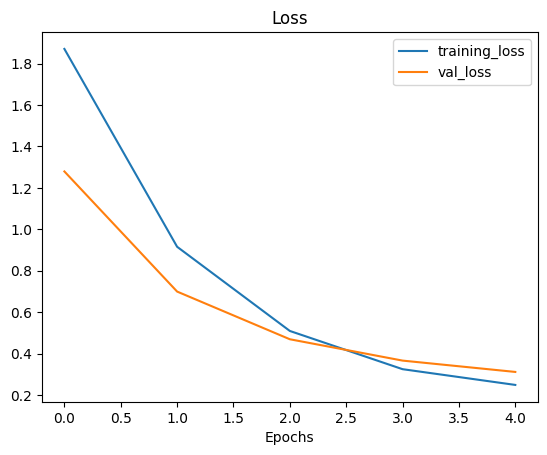

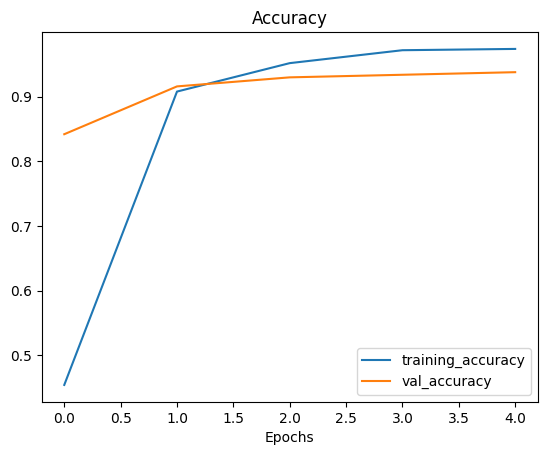

In [7]:
plot_loss_curves(history_0)

## 3. Use Data Augmentation

We will use the smaller dataset thtacontain 25 images per class

In [8]:
images_paths = "/content/drive/MyDrive/my_projects/animal_classification/data_preprocessing_folder/transformed_dataset_25_images"

train_dir = images_paths + "/train"
test_dir = images_paths + "/test"
valid_dir = images_paths + "/valid"


In [9]:
# Create Datalodaers
train_data_25_images = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size = IMG_SIZE,
                                                              batch_size = BATCH_SIZE,
                                                              label_mode = "categorical")

test_data_25_images = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                            image_size = IMG_SIZE,
                                                                          batch_size = BATCH_SIZE,
                                                                          label_mode = "categorical")

valid_data_25_images = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                              image_size = IMG_SIZE,
                                                              batch_size = BATCH_SIZE,
                                                              label_mode = "categorical")
#

Found 250 files belonging to 10 classes.
Found 400 files belonging to 8 classes.
Found 500 files belonging to 10 classes.


In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.Input(shape = (224, 224, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
    #layers.Rescaling(1./255)
], name = "data_augmentation")

In [11]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_1 = create_base_model()


In [12]:
# Setup checkpoint path
checkpoint_path = "/content/drive/MyDrive/my_projects/animal_classification/tensorflow/ten_percent_model_checkpoints_weights/checkpoint.weights.h5" # note: remember saving directly to Colab is temporary

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3)
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

history_1 = model_1.fit(train_data_25_images,
            epochs = 10,
            validation_data = valid_data_25_images,
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback,early_stopping_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250103-165648
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1692 - loss: 2.2600 
Epoch 1: val_loss improved from inf to 1.82253, saving model to /content/drive/MyDrive/my_projects/animal_classification/tensorflow/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 317s 41s/step - accuracy: 0.1793 - loss: 2.2466 - val_accuracy: 0.5400 - val_loss: 1.8225
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6152 - loss: 1.6549
Epoch 2: val_loss improved from 1.82253 to 1.36112, saving model to /content/drive/MyDrive/my_projects/animal_classification/tensorflow/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 831ms/step - accuracy: 0.6251 - loss: 1.6420 - val_accuracy: 0.7800 - val_loss: 1.3611
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8579 - loss: 1.1885
Epoch 3: val_loss improved from 1.36112 to 1

In [13]:
#results_10_percent_data_aug = model_1.evaluate(test_data_25_images)

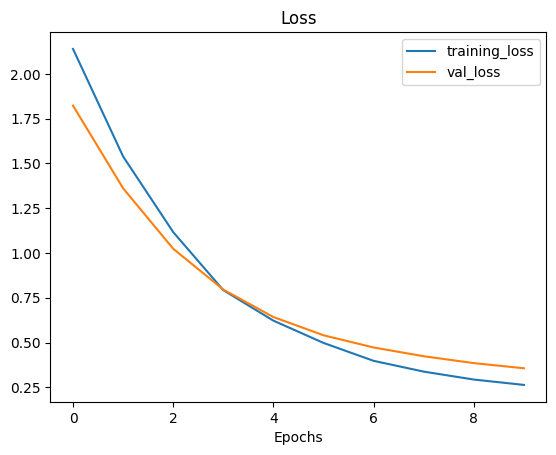

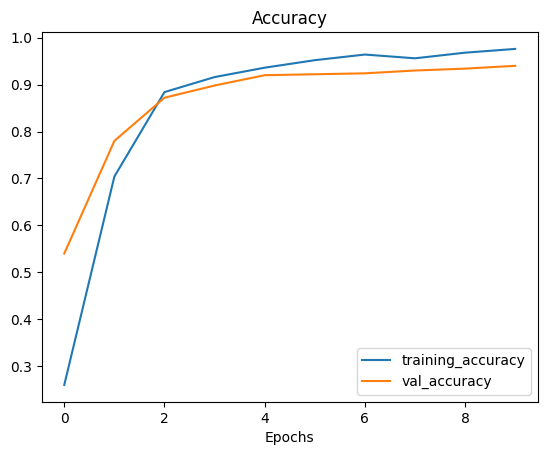

In [14]:
plot_loss_curves(history_1)

## 4. Fine Tuning
In this chapter we will use fine tuning to create a model. Furthermore, we will unfreeze the last 5 layers of the model.

In [15]:
# Creat Datalodaers for the dataset that contains 100 training images per class
image_path =  "/content/drive/MyDrive/my_projects/animal_classification/data_preprocessing_folder/transformed_dataset_100_images"

train_dir = image_path + '/train'
test_dir = image_path + '/test'
valid_dir = image_path + '/valid'

# Create dataloaders
train_data_100_images = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)

Found 1000 files belonging to 10 classes.
Found 500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [16]:
model_2 = create_base_model(input_shape = (224,224,3)
                    ,output_shape = len(train_data_100_images.class_names),
                    learning_rate = 0.0001,
                    training = True)

model_2.summary

<bound method Model.summary of <Functional name=functional_3, built=True>>

In [17]:
model_2.trainable = True

for layer in model_2.layers[:-10]:
  layer.trainable = False

model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])


In [18]:
initial_epochs = 5

fine_tune_epochs = initial_epochs + 5

history_fine_tunings = model_0.fit(train_data_100_images,
                                   epochs = fine_tune_epochs,
                                   initial_epoch = history_0.epoch[-1],
                                   validation_data = valid_data,
                                   callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250103-170337
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 593s 18s/step - accuracy: 0.9499 - loss: 0.2683 - val_accuracy: 0.9400 - val_loss: 0.2894
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.9564 - loss: 0.2612 - val_accuracy: 0.9440 - val_loss: 0.2723
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9463 - loss: 0.2559 - val_accuracy: 0.9500 - val_loss: 0.2577
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.9659 - loss: 0.2262 - val_accuracy: 0.9520 - val_loss: 0.2453
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.9740 - loss: 0.2138 - val_accuracy: 0.9520 - val_loss: 0.2349
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.9650 - loss: 0.2159 - val_accuracy: 0.9540 - val_loss: 0.2247
